## Notebook to test the difference in porosity and permeability by facies

In [1]:
# importing Python libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d.axes3d import Axes3D
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import scipy.stats as st
import seaborn as sns
import math

In [2]:
# loading declustered data - both raw and outliers removed
clean_sandstone = pd.read_csv('Data/DeclusteredSandstone.csv')
clean_shale = pd.read_csv('Data/DeclusteredShale.csv')
raw_sandstone = pd.read_csv('Data/DeclusteredRawSandstone.csv')
raw_shale = pd.read_csv('Data/DeclusteredRawShale.csv')
# removing the extra data column
del clean_sandstone['Unnamed: 0']
del clean_shale['Unnamed: 0']
del raw_sandstone['Unnamed: 0']
del raw_shale['Unnamed: 0']
# concatenate dataframes to recreate totalsets
raw_df = pd.concat([raw_sandstone, raw_shale])
clean_df = pd.concat([clean_sandstone, clean_shale])

### Plotting empirical pdfs and cdfs
Visually inspect the declustered distributions of porosity and permeability. First define the data set to be used, either the raw data or the data after the removal of outliers.

In [3]:
# set relevant dataframes to names sandstone and shale
    # can choose raw or clean data by specifying this assignment
sandstone = raw_sandstone
shale = raw_shale

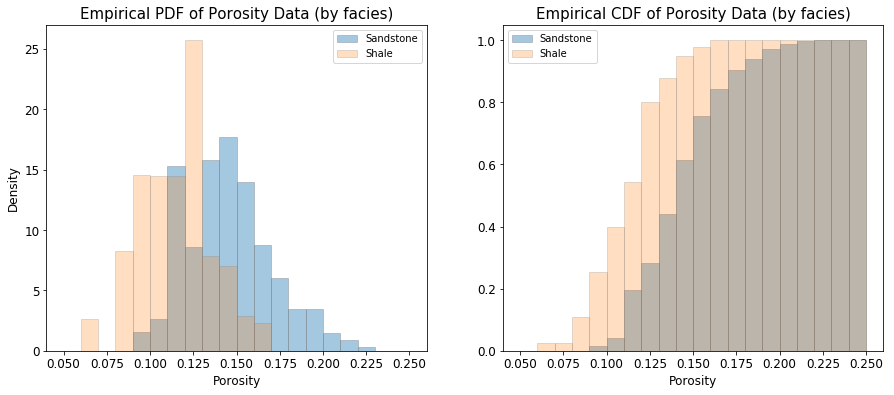

In [4]:
# plotting the empirical pdf and cdf of the porosity data
plt.figure(figsize=(15,6))

# pdf of porosity data by facies 
plt.subplot(121)
vmin = 0.05; vmax = 0.25; # range of porosity values
im_sand = plt.hist(sandstone['Porosity'], edgecolor='gray', density=True,weights=sandstone['Wts'],
                   bins=20, alpha=0.4, range=[vmin,vmax],label='Sandstone')
im_shale = plt.hist(shale['Porosity'], edgecolor='gray', density=True,weights=shale['Wts'],
                    bins=20, alpha=0.25, range=[vmin,vmax],label='Shale')
plt.title('Empirical PDF of Porosity Data (by facies)',size=15)
plt.ylabel('Density',size=12)
plt.xlabel('Porosity',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

# cdf of porosity data by facies
plt.subplot(122)
im_sand = plt.hist(sandstone['Porosity'], edgecolor='gray', density=True,weights=sandstone['Wts'],
                   cumulative=True, bins=20, alpha=0.4, range=[vmin,vmax],label='Sandstone')
im_shale = plt.hist(shale['Porosity'], edgecolor='gray', density=True,weights=shale['Wts'],
                    cumulative=True, bins=20, alpha=0.25, range=[vmin,vmax],label='Shale')
plt.title('Empirical CDF of Porosity Data (by facies)',size=15)
plt.xlabel('Porosity',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')

plt.show()

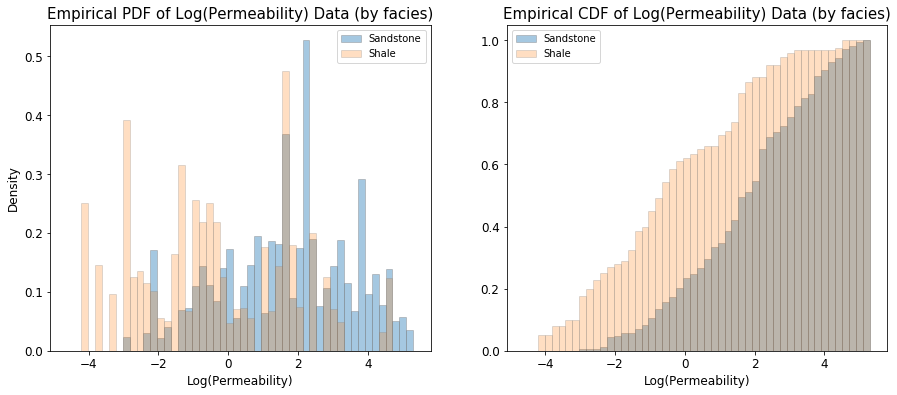

In [5]:
# plotting the empirical pdf and cdf of the permeability data
plt.figure(figsize=(15,6))

# pdf of porosity data by facies 
plt.subplot(121)
vmin = 0.01; vmax = 200; # range of permeability values
im_sand = plt.hist(np.log(sandstone['Perm']), edgecolor='gray', density=True,weights=sandstone['Wts'],
                   bins=50, alpha=0.4, range=[np.log(vmin),np.log(vmax)],label='Sandstone')
im_shale = plt.hist(np.log(shale['Perm']), edgecolor='gray', density=True,weights=shale['Wts'],
                    bins=50, alpha=0.25, range=[np.log(vmin),np.log(vmax)],label='Shale')
plt.title('Empirical PDF of Log(Permeability) Data (by facies)',size=15)
plt.ylabel('Density',size=12)
plt.xlabel('Log(Permeability)',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

# cdf of porosity data by facies
plt.subplot(122)
im_sand = plt.hist(np.log(sandstone['Perm']), edgecolor='gray', density=True,weights=sandstone['Wts'],
                   cumulative=True, bins=50, alpha=0.4, range=[np.log(vmin),np.log(vmax)],label='Sandstone')
im_shale = plt.hist(np.log(shale['Perm']), edgecolor='gray', density=True,weights=shale['Wts'],
                    cumulative=True, bins=50, alpha=0.25, range=[np.log(vmin),np.log(vmax)],label='Shale')
plt.title('Empirical CDF of Log(Permeability) Data (by facies)',size=15)
plt.xlabel('Log(Permeability)',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')

plt.show()

### Computing Declustered Statistics for Porosity

In [6]:
def weighted_avg_and_std(values, weights): # function to calculate weighted mean and st. dev., from Eric O Lebigot, stack overflow,
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

sandstone_avg, sandstone_stdev = weighted_avg_and_std(sandstone['Porosity'],sandstone['Wts'])
print('Sandstone: Declustered mean = ' + str(round(sandstone_avg,3)) + ' and declustered standard deviation = ' + str(round(sandstone_stdev,3)))
print('')
shale_avg, shale_stdev = weighted_avg_and_std(shale['Porosity'],shale['Wts'])
print('Shale: Declustered mean = ' + str(round(shale_avg,3)) + ' and declustered standard deviation = ' + str(round(shale_stdev,3)))

Sandstone: Declustered mean = 0.145 and declustered standard deviation = 0.025

Shale: Declustered mean = 0.115 and declustered standard deviation = 0.021


### T-Test and Welch's T-Test for Porosity

In [7]:
alpha = 0.05
# t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=True)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity T-Test Results:')
print('p-value from the t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

# Welch's t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=False)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity Welch\'s T-Test Results:')
print('p-value from the Welch\'s t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

Porosity T-Test Results:
p-value from the t-test was 0.0
Therefore, we reject the null hypothesis, mean values are statistically different

Porosity Welch's T-Test Results:
p-value from the Welch's t-test was 0.0
Therefore, we reject the null hypothesis, mean values are statistically different



### Computing Declustered Statistics for Permeability

In [8]:
sandstone_avg, sandstone_stdev = weighted_avg_and_std(sandstone['Perm'],sandstone['Wts'])
print('Sandstone: Declustered mean = ' + str(round(sandstone_avg,3)) + ' and declustered standard deviation = ' + str(round(sandstone_stdev,3)))
print('')
shale_avg, shale_stdev = weighted_avg_and_std(shale['Perm'],shale['Wts'])
print('Shale: Declustered mean = ' + str(round(shale_avg,3)) + ' and declustered standard deviation = ' + str(round(shale_stdev,3)))

Sandstone: Declustered mean = 480.609 and declustered standard deviation = 2509.476

Shale: Declustered mean = 7.031 and declustered standard deviation = 23.642


### T-Test and Welch's T-Test for Permeability

In [9]:
alpha = 0.05
# t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=True)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity T-Test Results:')
print('p-value from the t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

# Welch's t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=False)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity Welch\'s T-Test Results:')
print('p-value from the Welch\'s t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

Porosity T-Test Results:
p-value from the t-test was 0.13898
Therefore, we accept the null hypothesis, mean values are statistically similar

Porosity Welch's T-Test Results:
p-value from the Welch's t-test was 0.00692
Therefore, we reject the null hypothesis, mean values are statistically different



In [10]:
print(sandstone_stdev)
print(shale_stdev)

2509.476134017255
23.641511757602736


In [11]:
p_value = 1 - st.f.cdf(sandstone_stdev**2/shale_stdev**2, dfn=len(sandstone)-1, dfd=len(shale)-1)
print('The p-value for the F-test for difference is variances is ' + str(round(p_value,3)))

The p-value for the F-test for difference is variances is 0.0


The p-value from the F-test is less than our alpha of 0.05, and so we would conclude that the variances between the facies are statistically different and therefore unequal. This would suggest that the Welch's T-test is more appropriate for assessing the difference in mean values as it does not assume equal variance (which we have now proven to be a poor assumption). So therefore we will accept the result from the Welch test and say that the mean values are statistically different.

### Conclusions
P-values for both the standard t-test and Welch's t-test on the declustered statistics for the distributions split by facies indicate that the distribution of porosity, by facies, is statistically different (to a 95\% confidence level). The permeability data was further tested using the F-test to check for equality of variances. This test revealed that the variances for the sandstone and shale data are statistically different, making the Welch test more appropriate to check the equality of the mean values. The Welch test indicated that the mean values for permeability by facies are statistically different.